# Logistic Regression
In this lab session we will implement logistic regression to classify gender given the height and weight.

In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [2]:
def load_data(sub_sample=True, add_outlier=False):
    """Load data and convert it to the metric system."""
    path_dataset = "Data/height_weight_genders.csv"
    data = np.genfromtxt(
        path_dataset, delimiter=",", skip_header=1, usecols=[1, 2])
    height = data[:, 0]
    weight = data[:, 1]
    gender = np.genfromtxt(
        path_dataset, delimiter=",", skip_header=1, usecols=[0],
        converters={0: lambda x: 0 if b"Male" in x else 1})
    # Convert to metric system
    height *= 0.025
    weight *= 0.454
    return height, weight, gender


def sample_data(y, x, seed, size_samples):
    """sample from dataset."""
    np.random.seed(seed)
    num_observations = y.shape[0]
    random_permuted_indices = np.random.permutation(num_observations)
    y = y[random_permuted_indices]
    x = x[random_permuted_indices]
    return y[:size_samples], x[:size_samples]


def standardize(x):
    """Standardize the original data set."""
    mean_x = np.mean(x, axis=0)
    x = x - mean_x
    std_x = np.std(x, axis=0)
    x = x / std_x
    return x, mean_x, std_x


def de_standardize(x, mean_x, std_x):
    """Reverse the procedure of standardization."""
    x = x * std_x
    x = x + mean_x
    return x

### Question 1
Load the data, sample 200 datapoints, create the feature matrix X, and standardize it by removing the mean an dividing by the standard deviation.

In [3]:
# load data.
height, weight, gender = load_data()

# build sampled x and y.
seed = 1
y = np.expand_dims(gender, axis=1)
X = np.c_[height.reshape(-1), weight.reshape(-1)]
y, X = sample_data(y, X, seed, size_samples=200)
x, mean_x, std_x = standardize(X)

### Question 2
define the function `sigmoid(t)` that takes the input and applies the sigmoid function to it <br>
$h(t) = \frac{1}{1+e^{-t}}$

In [4]:
def sigmoid(t):
    """apply sigmoid function on t."""
    sig = 1.0/(1.0+np.exp(-t))
    return sig

### Question 3
define the function `calculate_loss(y, tx, theta)` that calculates the logistic loss function
$J(\theta) = -\frac{1}{N}\sum_{i=1}^{N} \left[y^{(i)}log\left(h_\theta(x^{(i)})\right) + \left(1-y^{(i)}\right)log\left(1-h_\theta(x^{(i)})\right)\right]$

In [5]:
def calculate_loss(y, tx, theta):
    """compute the cost by negative log likelihood."""
    Lw = 0
    N = len(y)
    for i in range(N):
        Lw = Lw - (y[i]*np.log(sigmoid(np.dot(tx[i,:],theta))) + (1-y[i])*np.log(1.0-sigmoid(np.dot(tx[i,:],theta))))
    Lw = Lw/N
    return Lw

### Question 4
define the function `calculate_gradient(y, tx, theta)` that calculates the gradient of the logistic loss <br>
$\frac{\partial J}{\partial \theta_j} = \frac{1}{N}\sum_{i=1}^{N} \left(h_\theta\left(x^{(i)}\right)-y^{(i)}\right)x_{j}^{(i)}$ <br>
or in matrix form: <br>
$\nabla_\theta J = \frac{1}{N} X^T \cdot \left(h\left(X \cdot \theta\right) - Y\right)$

In [6]:
def calculate_gradient(y, tx, theta):
    """compute the gradient of loss."""
    Xw = sigmoid(np.dot(tx,theta))
    Gradw = (1/len(y))*np.dot(tx.T,Xw-y.reshape((-1,1)))
    return Gradw

### Question 5
define the function `learning_by_gradient_descent(y, tx, theta, gamma)` that does one step of gradient descent, return the loss and update the coefficient: <br>
$\theta_j := \theta_j - \alpha\frac{\partial}{\partial \theta_j}j(\theta)$ <br>
or in matrix form: <br>
$\theta := \theta - \alpha\nabla_\theta J$

In [7]:
def learning_by_gradient_descent(y, tx, theta, gamma):
    """
    Do one step of gradient descent using logistic regression.
    Return the loss and the updated theta.
    """
    Gradw = calculate_gradient(y, tx, theta)
    loss = calculate_loss(y, tx, theta)
    theta = theta - Gradw*gamma
    return loss, theta

### Question 6
define the function `build_poly(x, degree)` that expands the feature matrix X polynomially according to the degree.

In [8]:
def build_poly(x, degree):
    """Polynomial expansion of x with the given degree"""
    phi = np.ones((x.shape[0],1))
    for i in range(x.shape[1]):
        for j in range(degree):
            xi = x[:,i].reshape((-1,1))**(j+1)
            phi = np.concatenate((phi,xi),axis = 1)
    
    return phi

The function `visualization()` is used to visualize the learning progress by plotting the data and the classification borders

In [9]:
def visualization(y, x, mean_x, std_x, theta, degree):
    """visualize the raw data as well as the classification result."""
    fig, ax = plt.subplots()
    # plot raw data
    x = de_standardize(x, mean_x, std_x)
    males = np.where(y == 0)
    females = np.where(y == 1)
    # plot raw data with decision boundary
    height = np.arange(
        np.min(x[:, 0]), np.max(x[:, 0]) + 0.01, step=0.01)
    weight = np.arange(
        np.min(x[:, 1]), np.max(x[:, 1]) + 0.01, step=0.01)
    hx, hy = np.meshgrid(height, weight)
    hxy = (np.c_[hx.reshape(-1), hy.reshape(-1)] - mean_x) / std_x
    x_temp = build_poly(hxy, degree)
    prediction = x_temp.dot(-theta) > 0.0
    prediction = prediction.reshape((weight.shape[0], height.shape[0]))
    ax.contourf(hx, hy, prediction, 1)
    ax.scatter(
        x[males, 0], x[males, 1],
        marker='.', color=[0.06, 0.06, 1], s=20)
    ax.scatter(
        x[females, 0], x[females, 1],
        marker='*', color=[1, 0.06, 0.06], s=20)
    ax.set_xlabel("Height")
    ax.set_ylabel("Weight")
    ax.set_xlim([min(x[:, 0]), max(x[:, 0])])
    ax.set_ylim([min(x[:, 1]), max(x[:, 1])])
    plt.tight_layout()

### Question 7
define the function `logistic_regression_gradient_descent_demo(y, x, pol_degree=1)` that implements logistic regression on the data, and visualizes the training process.

In [16]:
def logistic_regression_gradient_descent_demo(y, x, pol_degree=1):
    # init parameters
    max_iter = 10000
    threshold = 1e-8
    gamma = 2.0
    losses = []

    # build tx
    tx = build_poly(x, pol_degree)
    theta = np.zeros((tx.shape[1], 1))
    visualization(y, x, mean_x, std_x, theta, pol_degree)

    # start the logistic regression
    for iter in range(max_iter):
        # get loss and update w.
        loss, theta = learning_by_gradient_descent(y, tx, theta, gamma)
        # log info
        if iter % 100 == 0:
            print("Current iteration={i}, loss={l}".format(i=iter, l=loss))
            visualization(y, x, mean_x, std_x, theta, pol_degree)
        # converge criterion
        losses.append(loss)
        if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
            break
    # visualization
    visualization(y, x, mean_x, std_x, theta, pol_degree)
    print("loss={l}".format(l=calculate_loss(y, tx, theta)))

Current iteration=0, loss=[0.69314718]
Current iteration=100, loss=[0.21732016]
Current iteration=200, loss=[0.20772946]
Current iteration=300, loss=[0.20549319]
Current iteration=400, loss=[0.20482435]
Current iteration=500, loss=[0.20460045]
Current iteration=600, loss=[0.20452094]
Current iteration=700, loss=[0.20449175]
Current iteration=800, loss=[0.20448082]
Current iteration=900, loss=[0.20447669]
loss=[0.20447515]


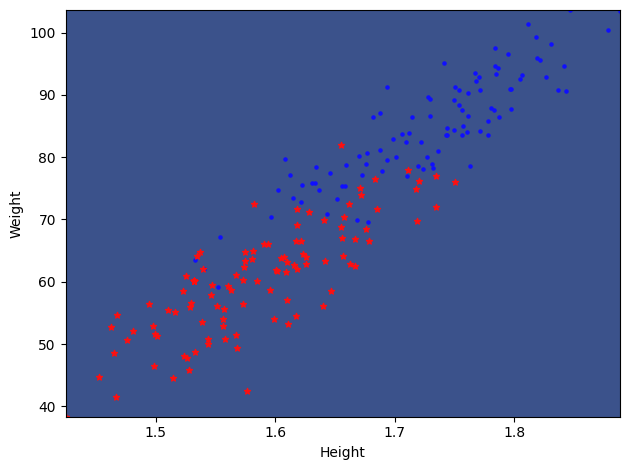

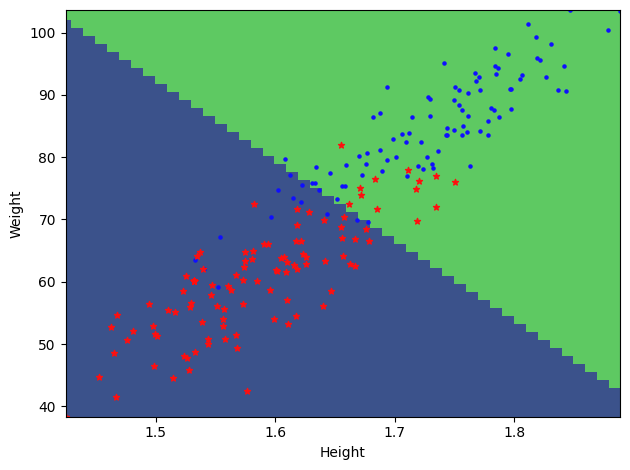

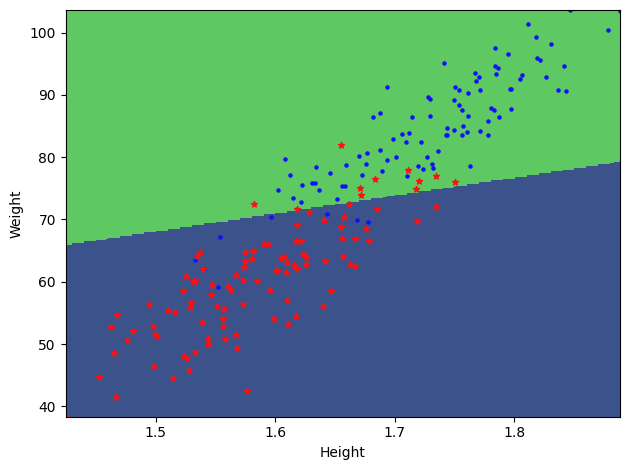

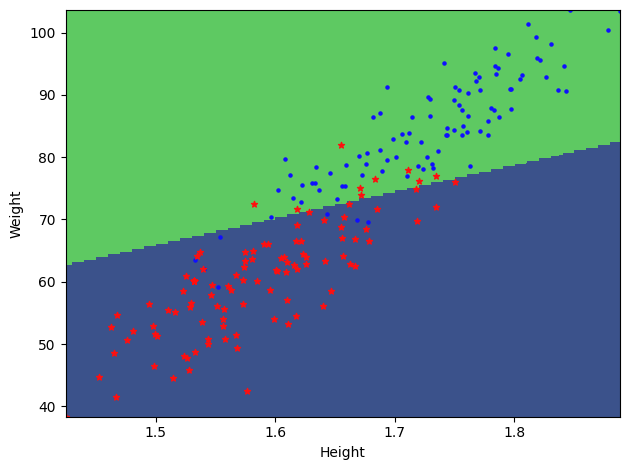

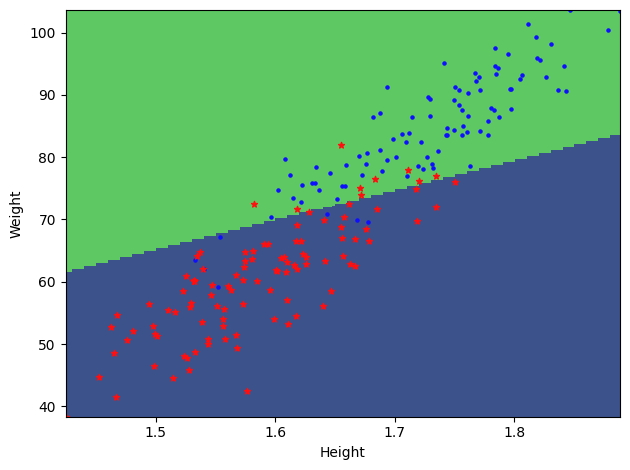

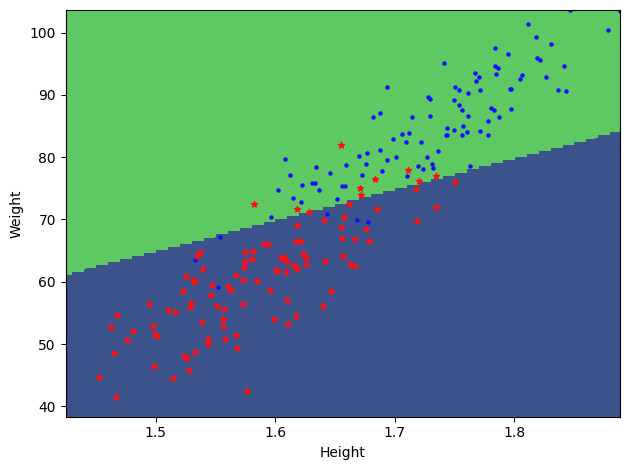

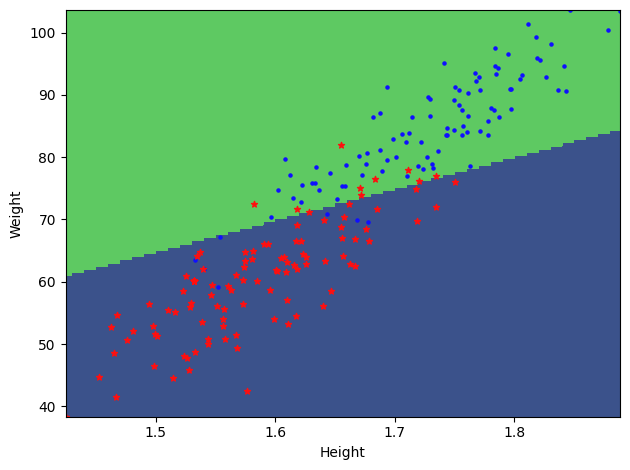

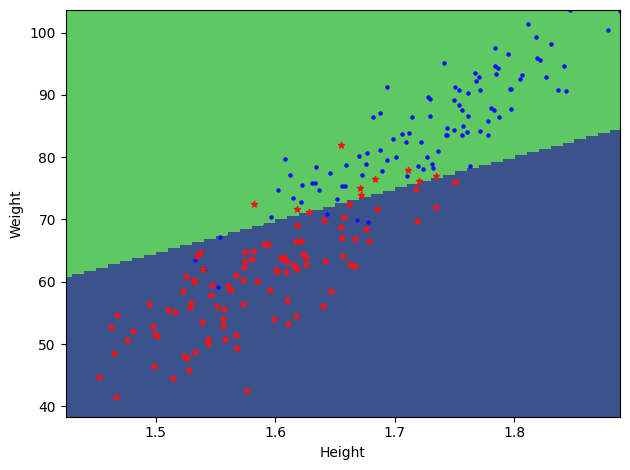

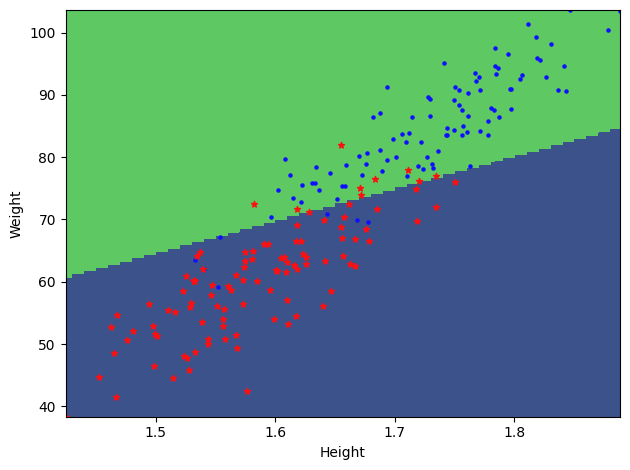

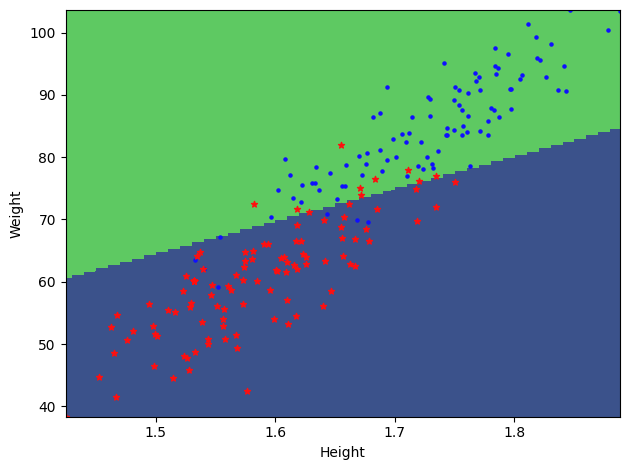

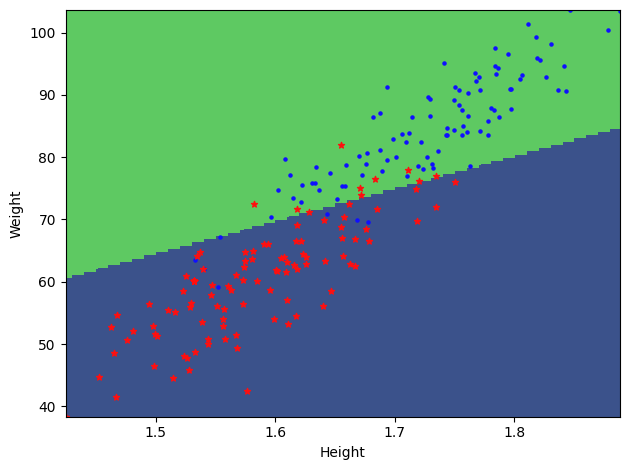

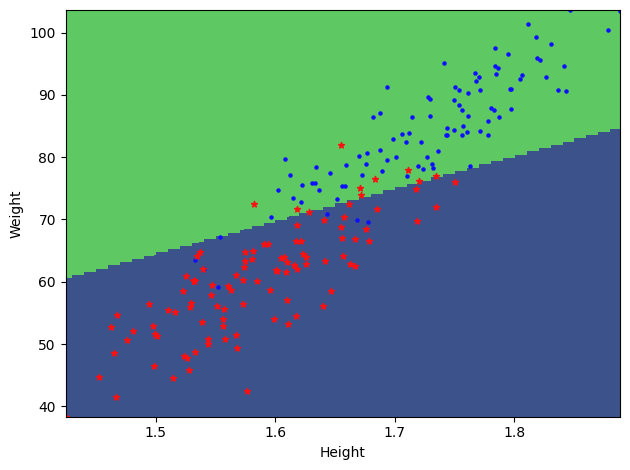

In [17]:
logistic_regression_gradient_descent_demo(y, x)

Current iteration=0, loss=[0.69314718]
Current iteration=100, loss=[0.21356856]
Current iteration=200, loss=[0.20344362]
Current iteration=300, loss=[0.20094155]
Current iteration=400, loss=[0.20014085]
Current iteration=500, loss=[0.19985144]
Current iteration=600, loss=[0.19973951]
Current iteration=700, loss=[0.19969438]
Current iteration=800, loss=[0.19967566]
Current iteration=900, loss=[0.19966775]
Current iteration=1000, loss=[0.19966435]
loss=[0.19966292]


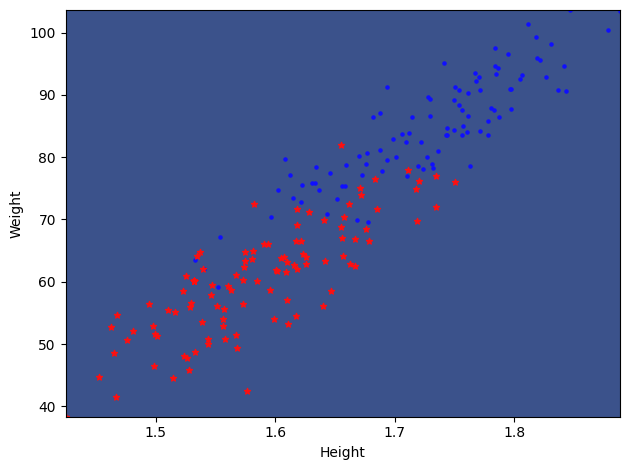

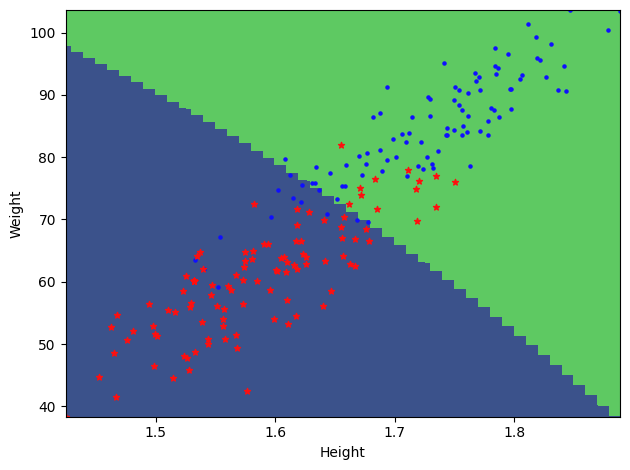

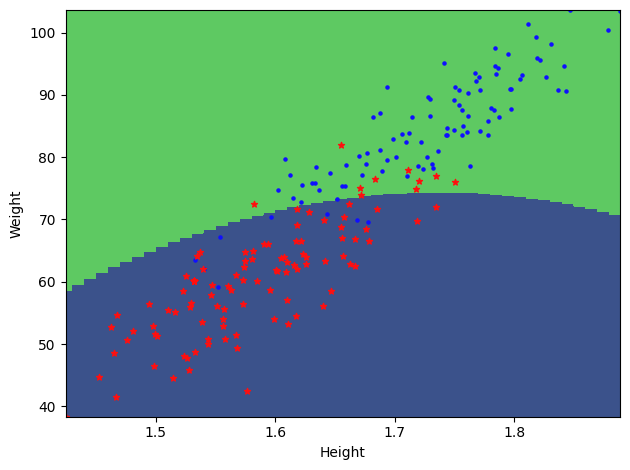

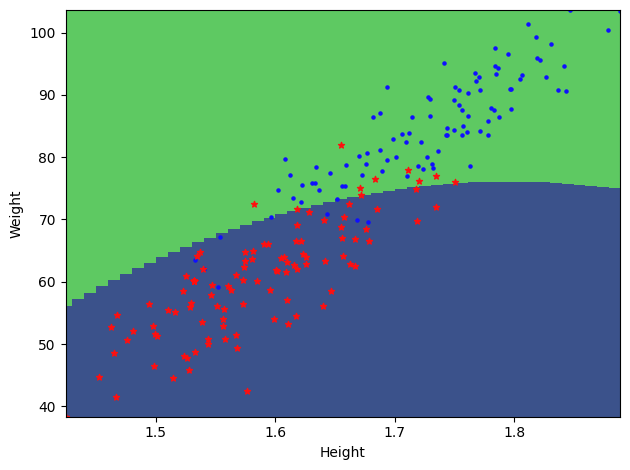

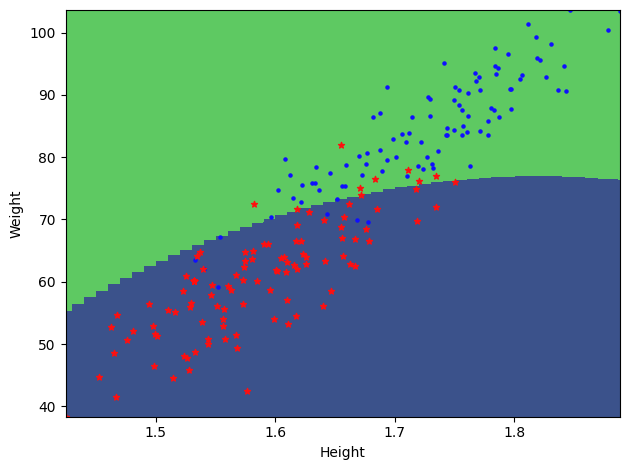

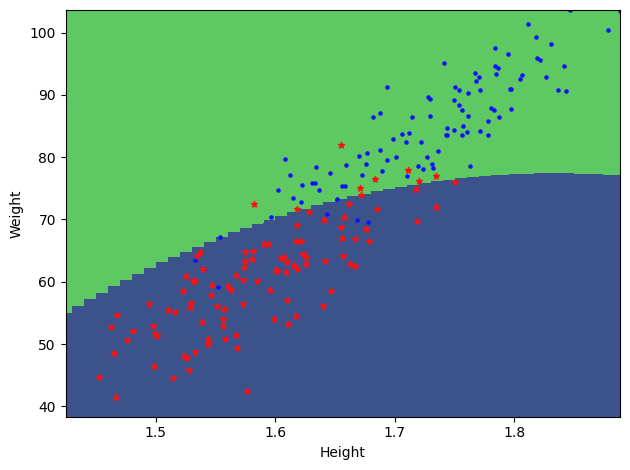

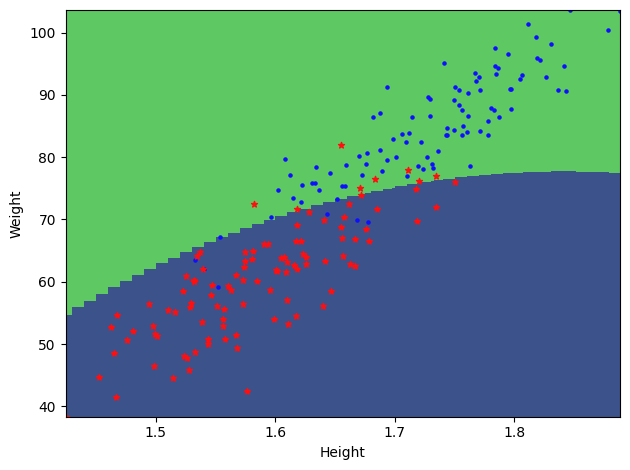

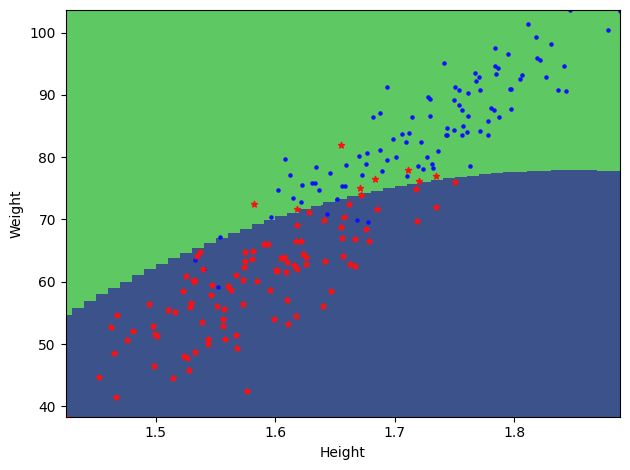

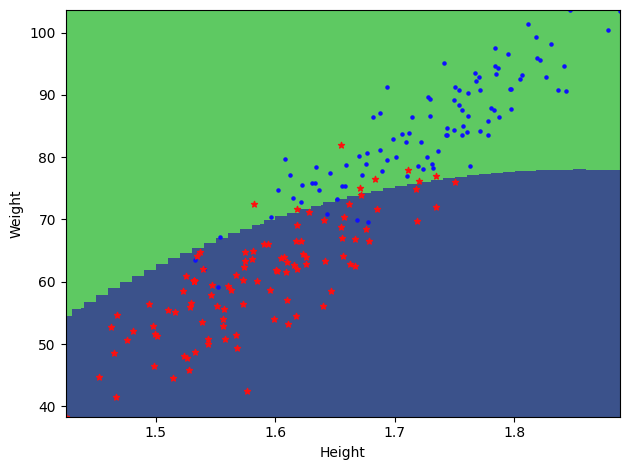

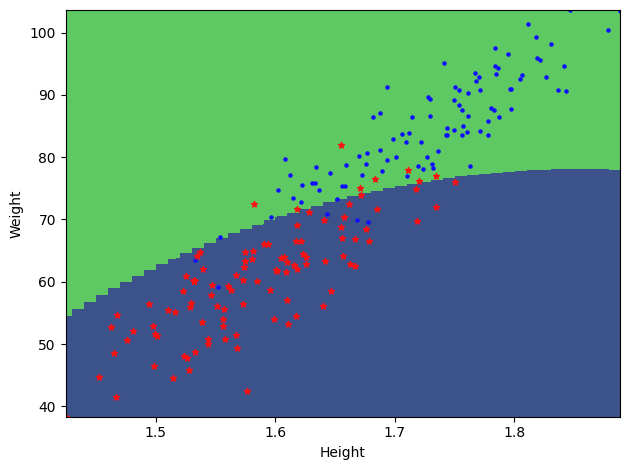

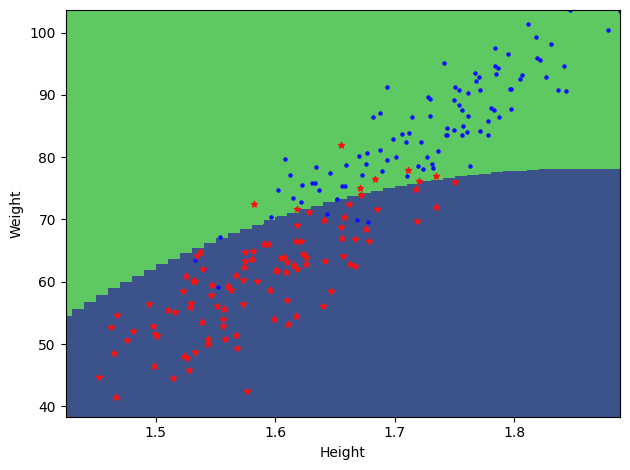

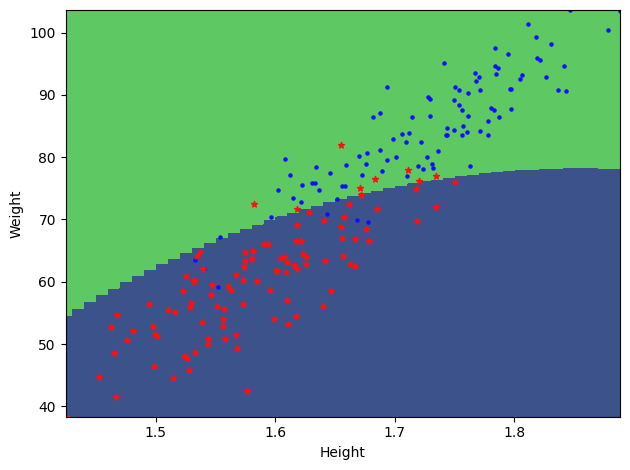

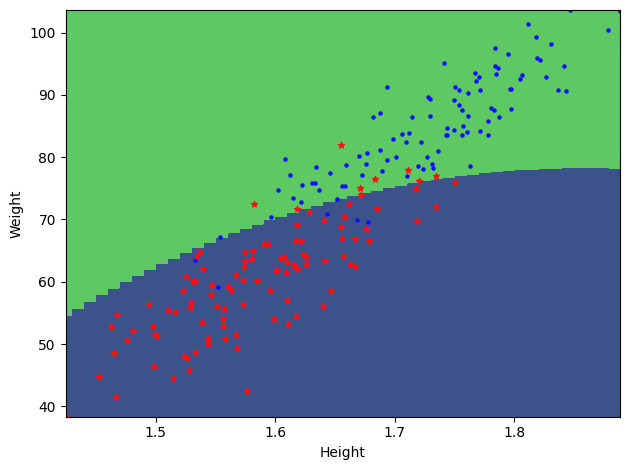

In [18]:
logistic_regression_gradient_descent_demo(y, x, pol_degree=2)

Current iteration=0, loss=[0.69314718]
Current iteration=100, loss=[0.2102172]
Current iteration=200, loss=[0.20260264]
Current iteration=300, loss=[0.20043303]
Current iteration=400, loss=[0.19944984]
Current iteration=500, loss=[0.19888323]
Current iteration=600, loss=[0.19851488]
Current iteration=700, loss=[0.19826092]
Current iteration=800, loss=[0.19808037]
Current iteration=900, loss=[0.19794947]
Current iteration=1000, loss=[0.19785305]
Current iteration=1100, loss=[0.19778096]
Current iteration=1200, loss=[0.19772625]
Current iteration=1300, loss=[0.19768415]
Current iteration=1400, loss=[0.19765131]
Current iteration=1500, loss=[0.1976254]
Current iteration=1600, loss=[0.19760475]
Current iteration=1700, loss=[0.19758815]
Current iteration=1800, loss=[0.19757472]
Current iteration=1900, loss=[0.1975638]


C:\Users\mecan\AppData\Local\Temp\ipykernel_28404\1467554794.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


Current iteration=2000, loss=[0.19755488]
Current iteration=2100, loss=[0.19754758]
Current iteration=2200, loss=[0.19754159]
Current iteration=2300, loss=[0.19753667]
Current iteration=2400, loss=[0.19753263]
Current iteration=2500, loss=[0.1975293]
Current iteration=2600, loss=[0.19752657]
Current iteration=2700, loss=[0.19752431]
Current iteration=2800, loss=[0.19752246]
Current iteration=2900, loss=[0.19752094]
Current iteration=3000, loss=[0.19751969]
loss=[0.197519]


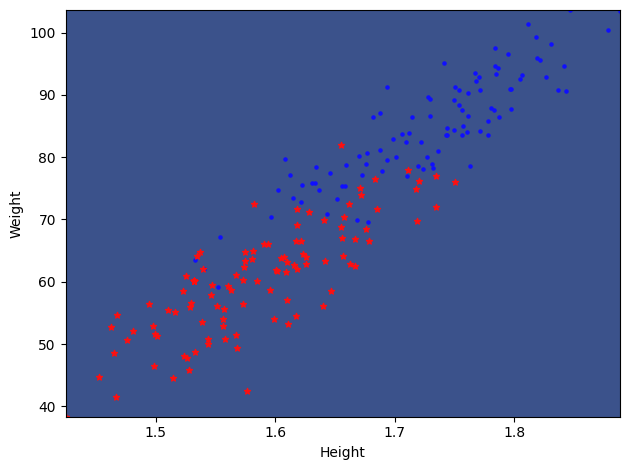

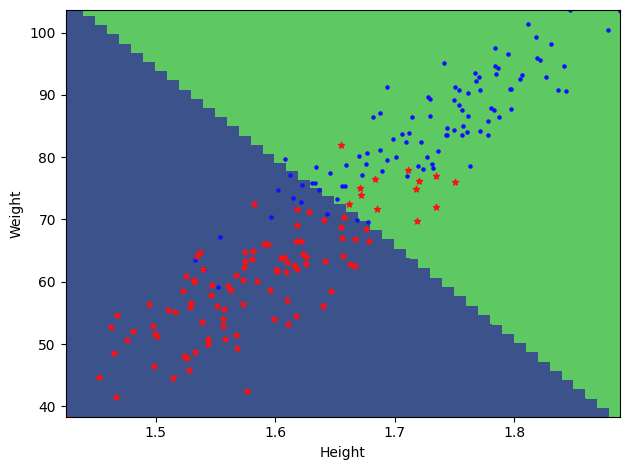

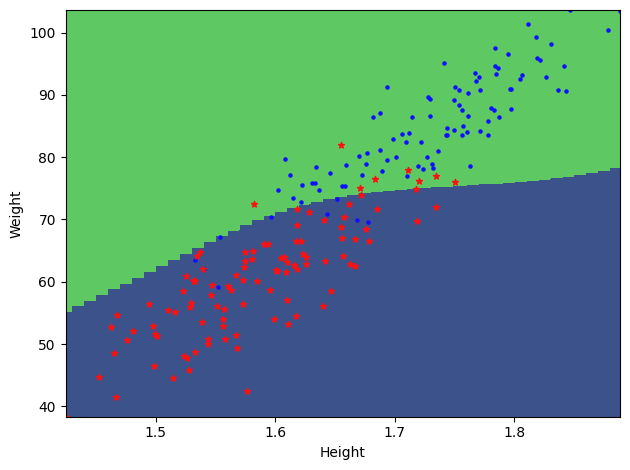

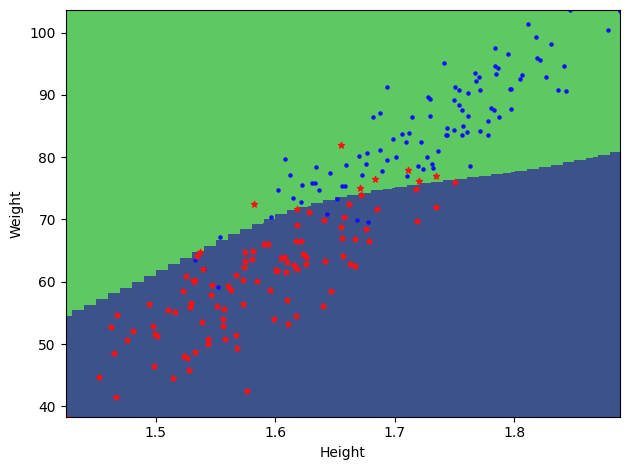

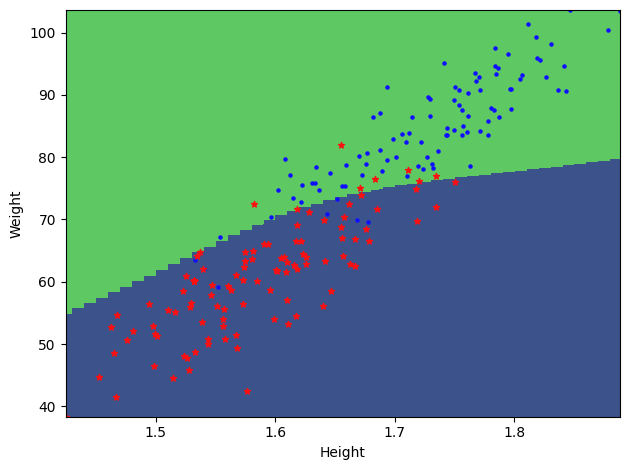

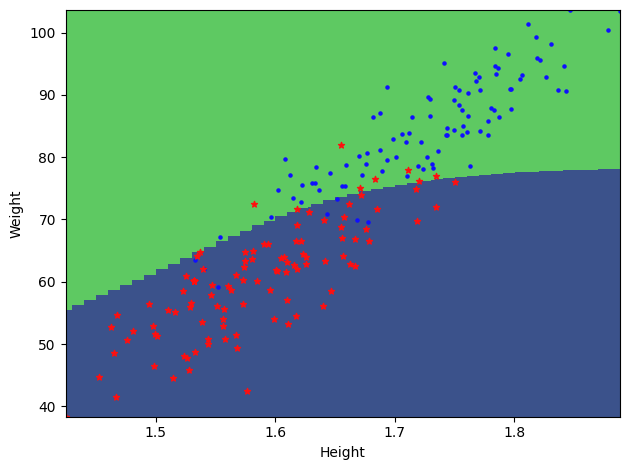

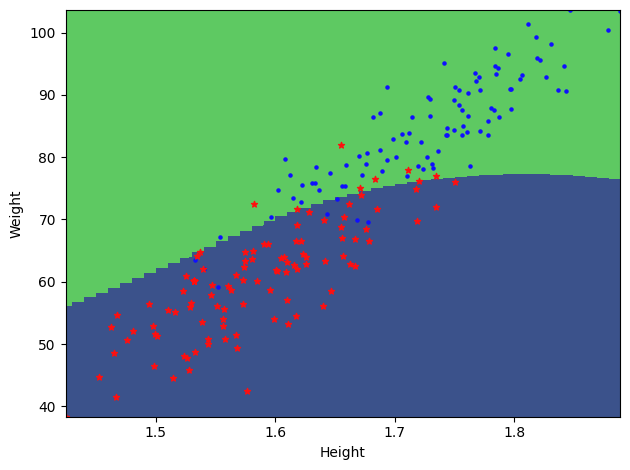

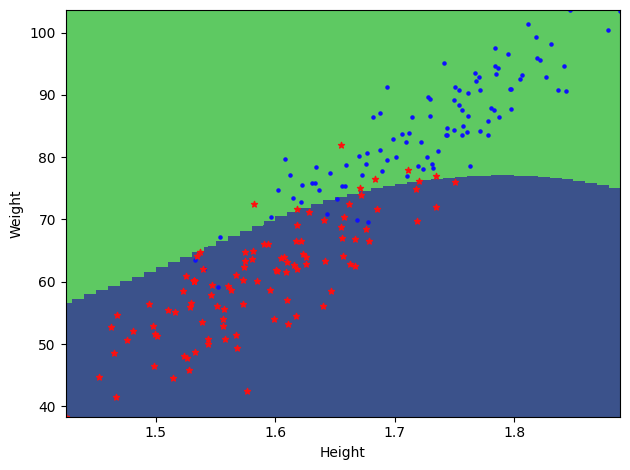

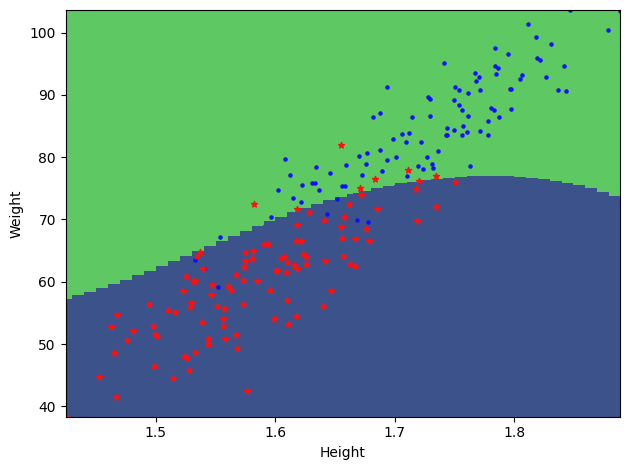

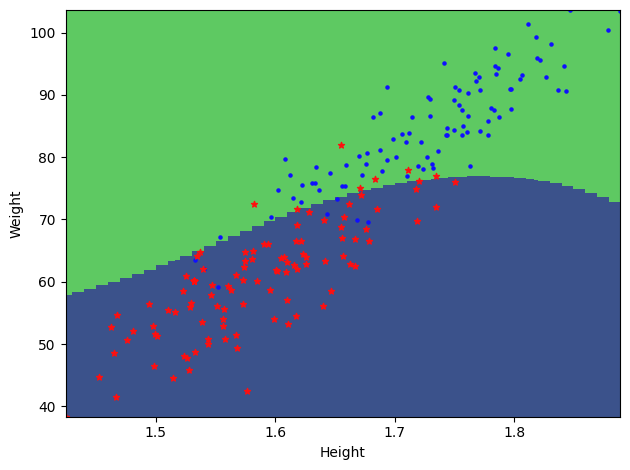

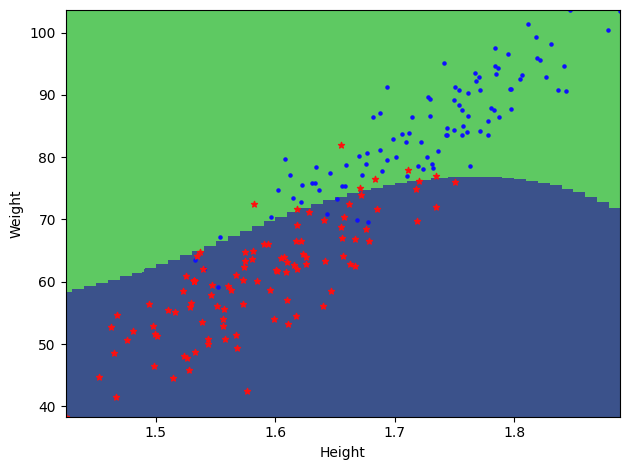

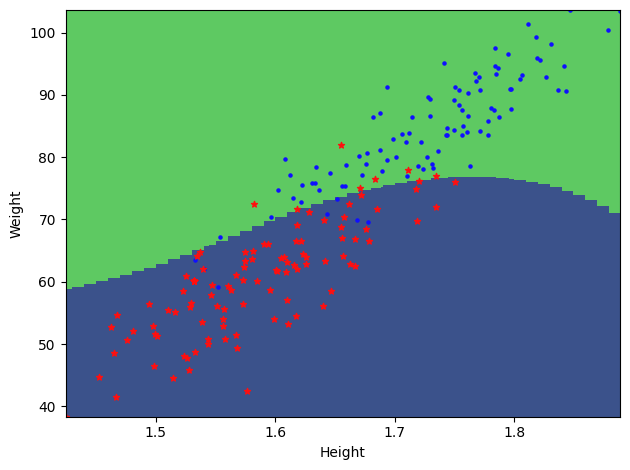

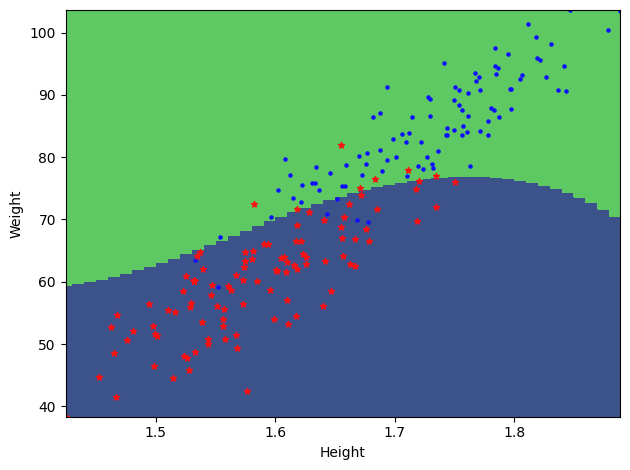

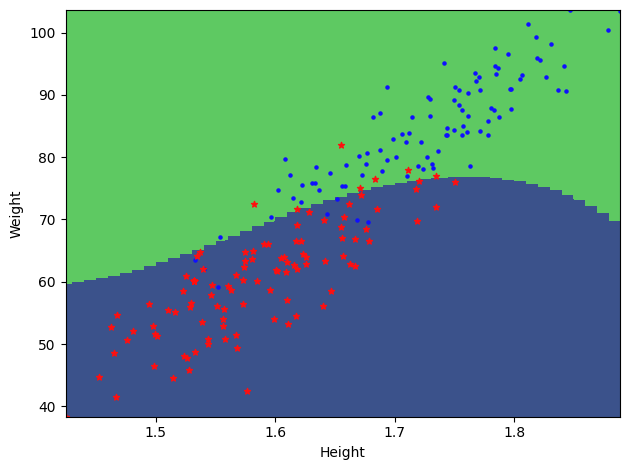

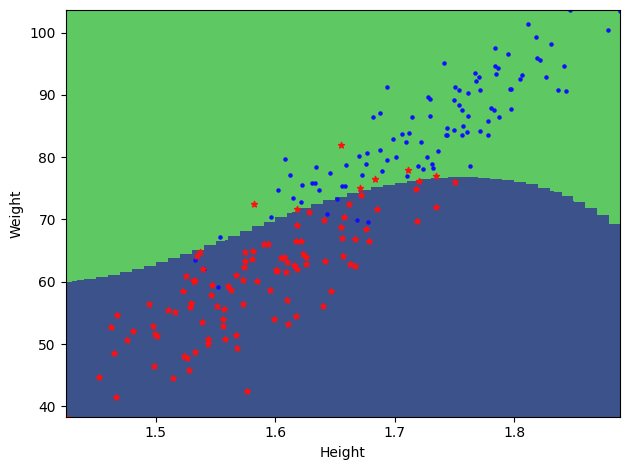

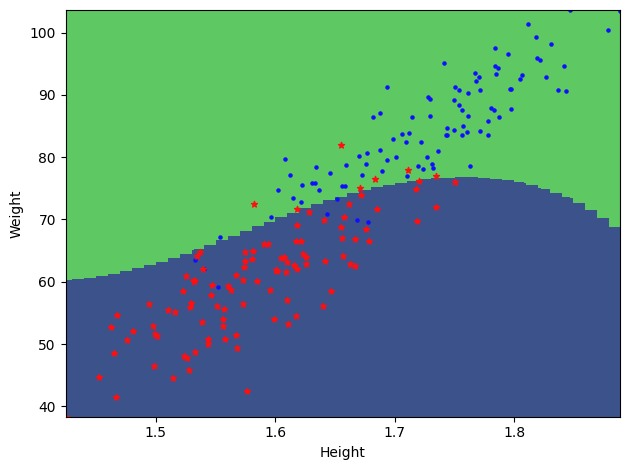

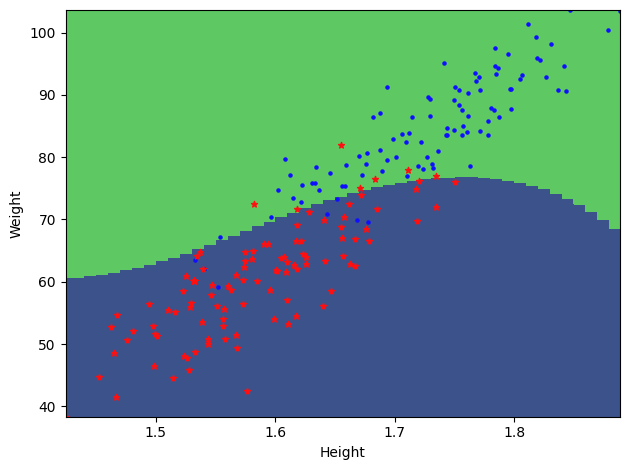

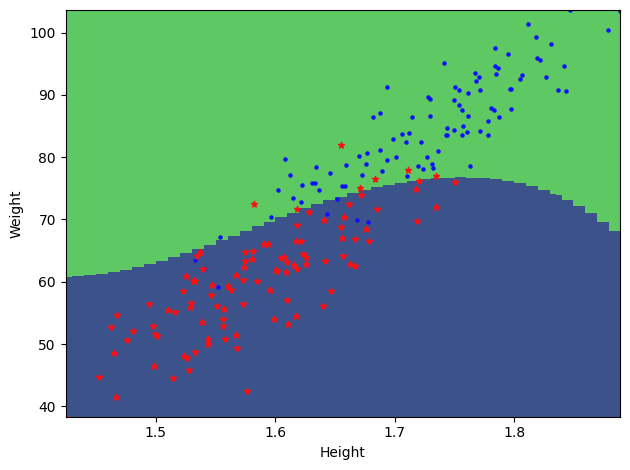

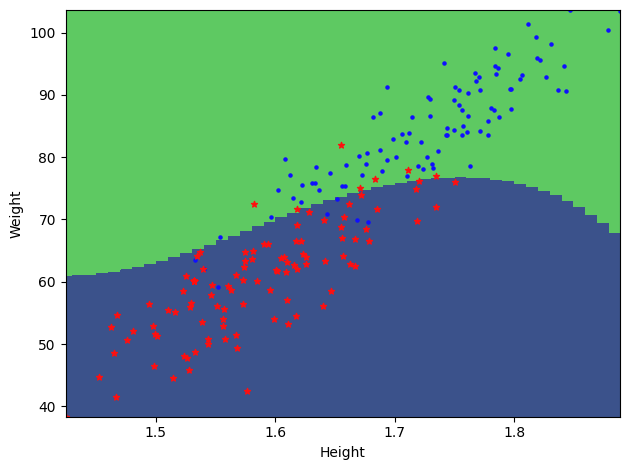

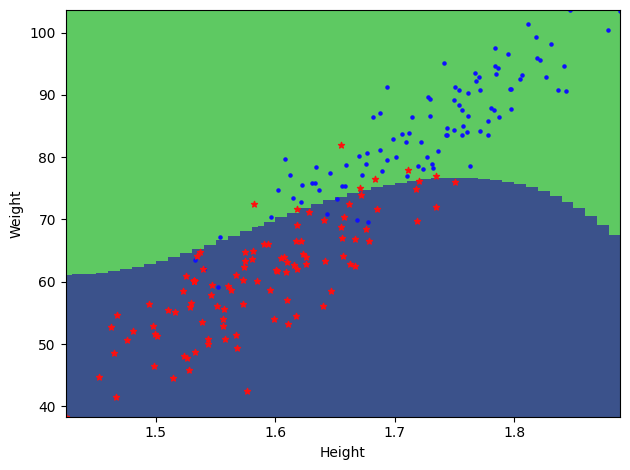

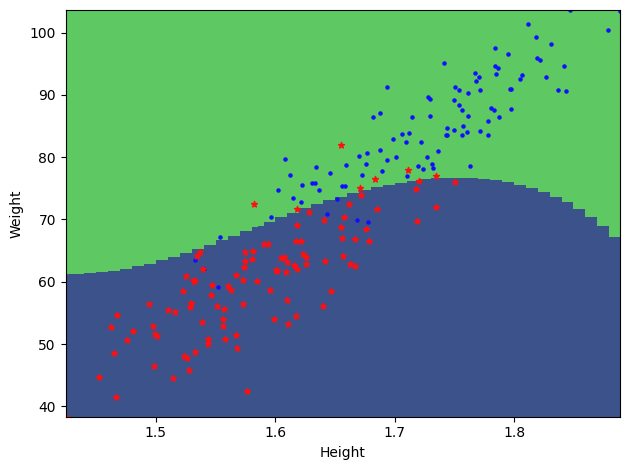

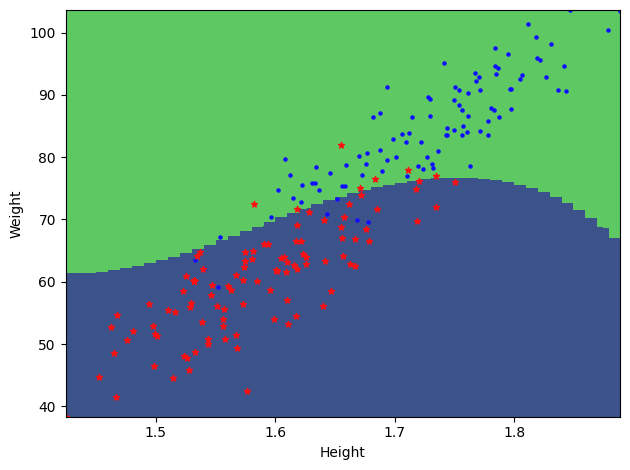

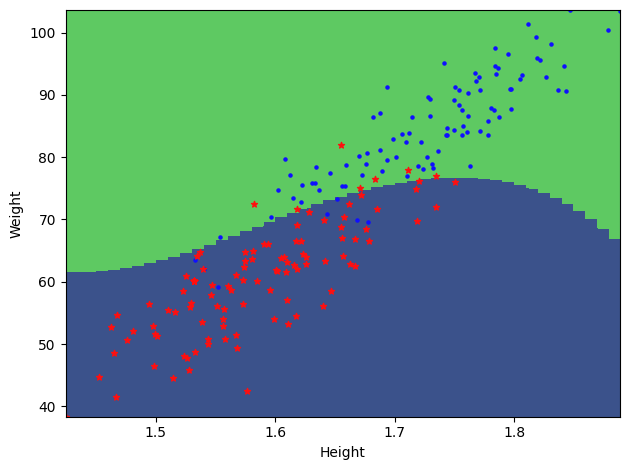

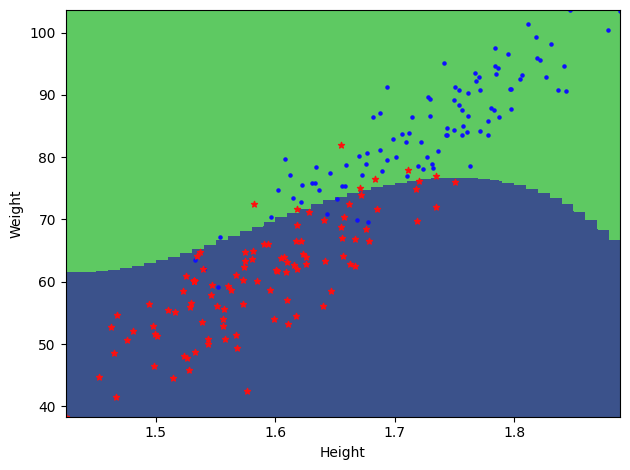

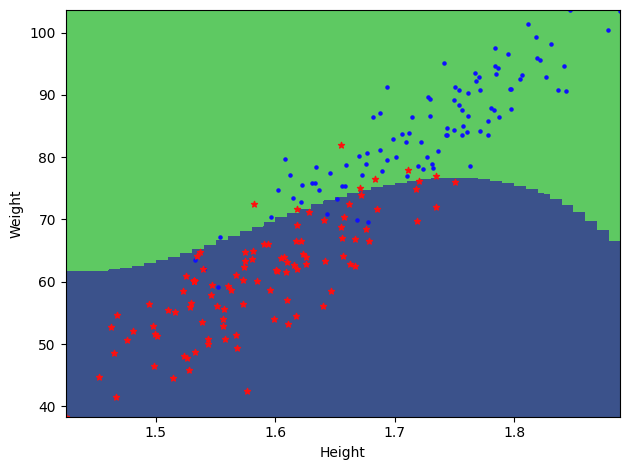

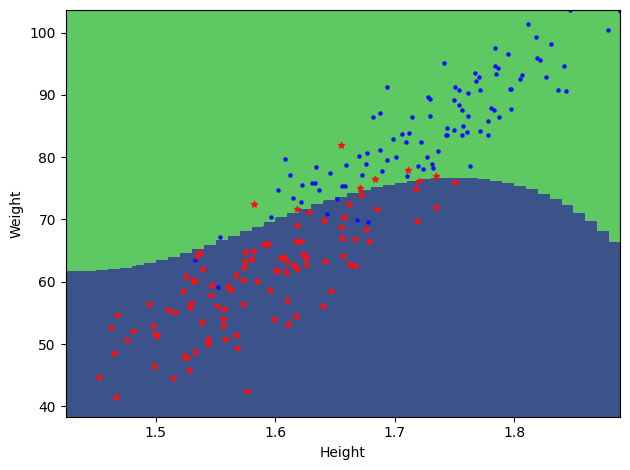

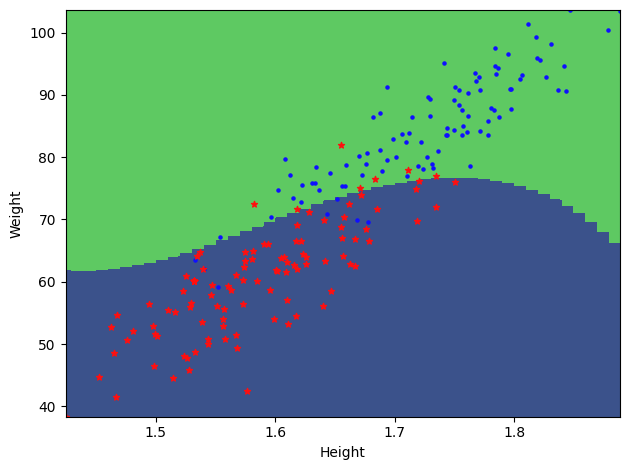

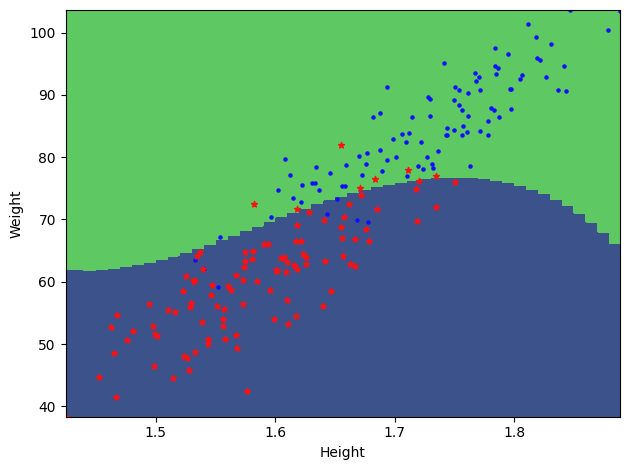

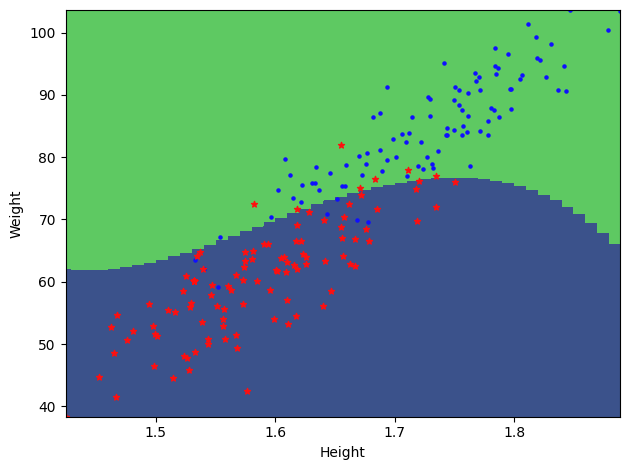

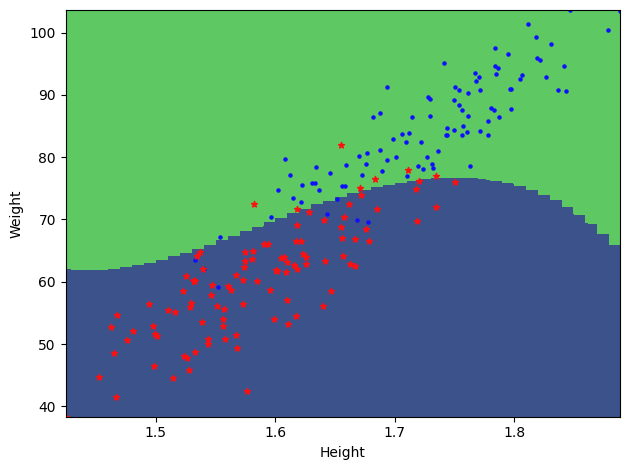

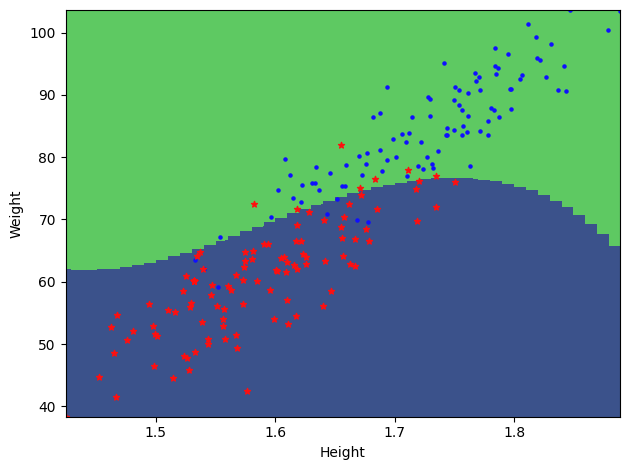

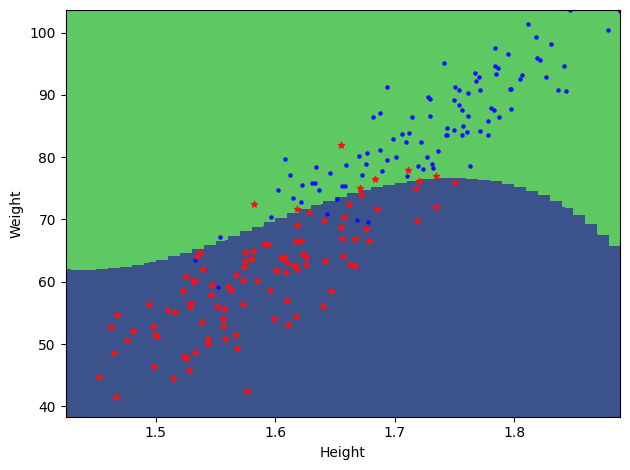

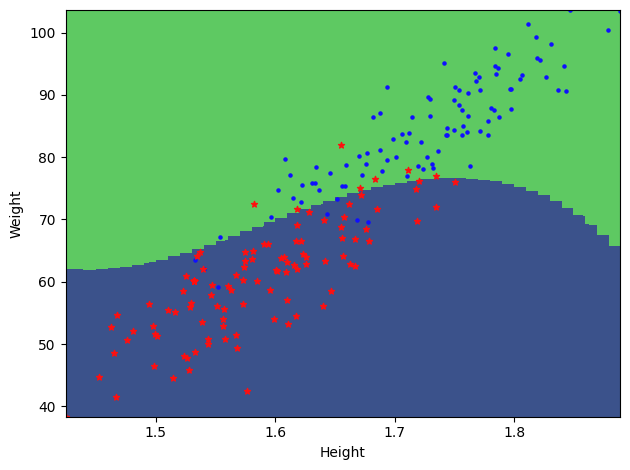

In [19]:
logistic_regression_gradient_descent_demo(y, x, pol_degree=3)

### Question 8
implement logistic regression with penalized gradient descent.
$\frac{\partial J}{\partial \theta_j} = \frac{1}{N}\left(\sum_{i=1}^{N} \left(h_\theta\left(x^{(i)}\right)-y^{(i)}\right)x_{j}^{(i)} + \lambda \theta_{j}\right)$

In [13]:
def learning_by_penalized_gradient(y, tx, theta, gamma, lambda_):
    """
    Do one step of gradient descent, using the penalized logistic regression.
    Return the loss and updated theta.
    """
    Gradw = calculate_gradient(y, tx, theta)
    Gradw = Gradw + (lambda_/len(y))*theta
    theta = theta - gamma*Gradw
    loss = calculate_loss(y, tx, theta)
    return loss, theta

In [14]:
def logistic_regression_penalized_gradient_descent_demo(y, x, pol_degree=1):
    # init parameters
    max_iter = 10000
    threshold = 1e-8
    gamma = 2.0
    lambda_ = 1.0
    losses = []

    # build tx
    tx = build_poly(x, pol_degree)
    theta = np.zeros((tx.shape[1], 1))
    visualization(y, x, mean_x, std_x, theta, pol_degree)

    # start the logistic regression
    for iter in range(max_iter):
        # get loss and update w.
        loss, theta = learning_by_penalized_gradient(y, tx, theta, gamma, lambda_)
        # log info
        if iter % 100 == 0:
            print("Current iteration={i}, loss={l}".format(i=iter, l=loss))
            visualization(y, x, mean_x, std_x, theta, pol_degree)
        # converge criterion
        losses.append(loss)
        if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
            break
    # visualization
    visualization(y, x, mean_x, std_x, theta, pol_degree)
    print("loss={l}".format(l=calculate_loss(y, tx, theta)))

Current iteration=0, loss=[0.31361523]
Current iteration=100, loss=[0.22715479]
Current iteration=200, loss=[0.22431839]
Current iteration=300, loss=[0.22397887]
Current iteration=400, loss=[0.22391438]


KeyboardInterrupt: 

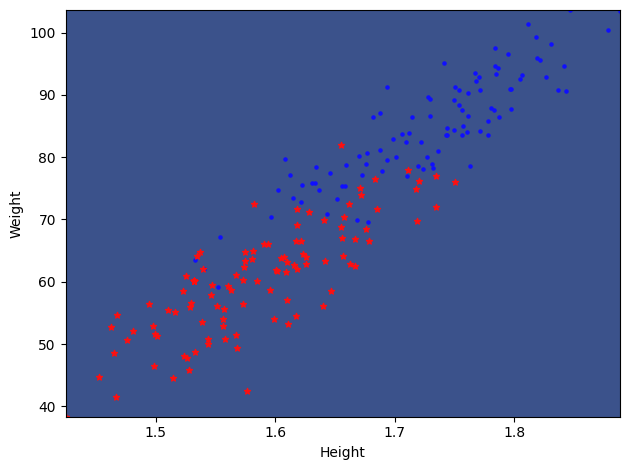

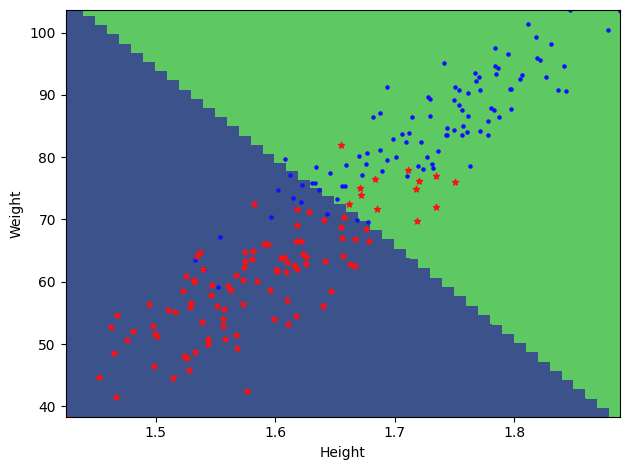

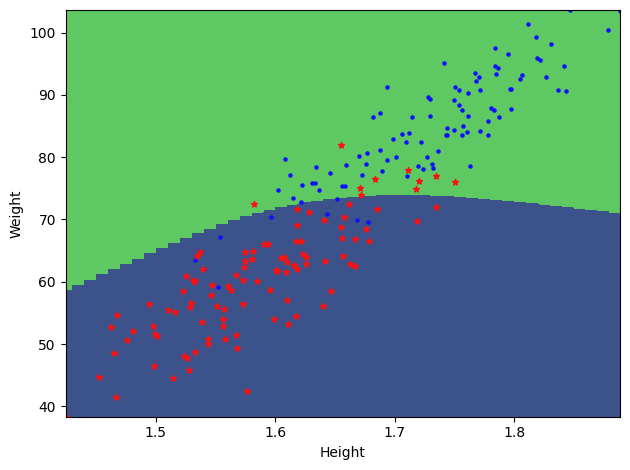

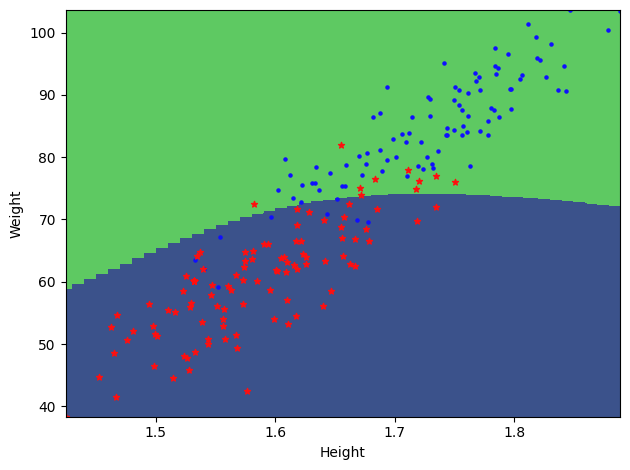

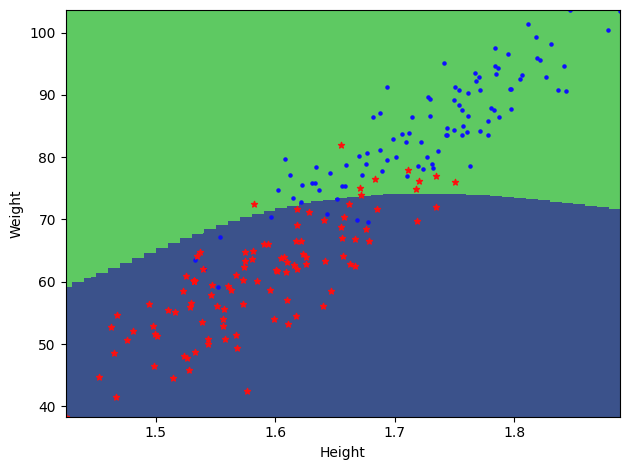

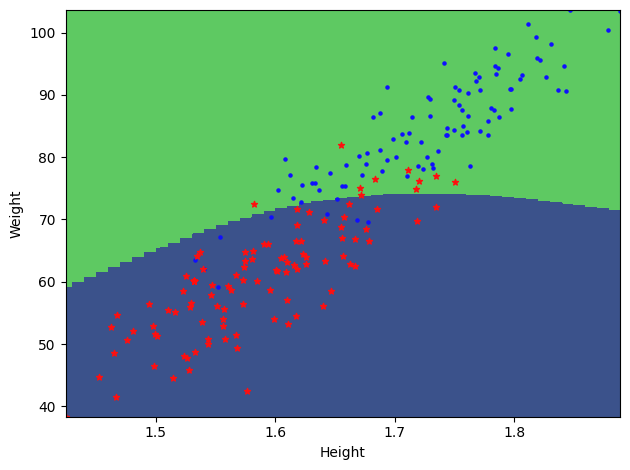

In [15]:
logistic_regression_penalized_gradient_descent_demo(y, x, pol_degree=3)